In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
import pandas as pd

# from llama_index import (Document)

# Load documents from the review dataset directory (adjust path as needed)
csv_path = "../Data/SPOTIFY_REVIEWS.csv"
df = pd.read_csv(csv_path, usecols=["review_text","review_rating","review_likes"])

In [ ]:
# remove rows with review text less than 5 tokens
def remove_short_lines(df, length=4):
    return df.loc[df["review_text"].str.count(" ") >= length]

def preprocess_text(df):
    df.drop_duplicates(subset=["review_text"], inplace=True)
    df.dropna(subset=["review_text"], inplace=True)
    df["review_text"] = (
        df["review_text"]
        .str.replace(r'\W+', ' ', regex=True)  # replace non-alphanumeric with space
        .str.replace(r'\s+', ' ', regex=True)  # collapse whitespace
        .str.lower()
    )
    return df

df = remove_short_lines(df)
df = preprocess_text(df)
df.head()

In [ ]:
import importlib
from symspellpy import SymSpell, Verbosity
from joblib import Parallel, delayed

# Load SymSpell dictionary (ensure you have "frequency_dictionary_en.txt")
dictionary_path = importlib.resources.files("symspellpy") / "frequency_dictionary_en_82_765.txt"
sym_spell = SymSpell(max_dictionary_edit_distance=2)
sym_spell.load_dictionary(str(dictionary_path), term_index=0, count_index=1)

def correct_spelling(text):
    words = text.split()  # Split the sentence into words
    corrected_words = [sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)[0].term if sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2) else word for word in words]
    return ' '.join(corrected_words)  # Reassemble the sentence

def correct_spelling_parallel_joblib(df):
    corrected_reviews = Parallel(n_jobs=-1)(delayed(correct_spelling)(text) for text in df['review_text'])
    df['review_text'] = corrected_reviews
    return df

# Apply to DataFrame
df = correct_spelling_parallel_joblib(df)


# df["review_text"] = df["review_text"].apply(lambda x: correct_spelling(x))
# df["review_text"] = correct_spelling_parallel(df)


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(df):
    df['review_text'] = df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

remove_stopwords(df)

In [ ]:
df = remove_short_lines(df, length=4)
df.shape

In [ ]:
df.head(15)

In [ ]:
import cudf
from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
from cuml.metrics.pairwise_distances import pairwise_distances
from tqdm import tqdm
import pandas as pd
import cupy as cp  # GPU-accelerated NumPy
import cupyx.scipy.sparse as cpx  # Sparse CuPy operations
from cuml.neighbors import NearestNeighbors  # RAPIDS GPU-optimized ANN

def vectorized_deduplicate_dataframe(df, text_column="review_text", threshold=0.8):
    """
    Efficiently deduplicates a dataframe based on text similarity using TF-IDF and cosine similarity on GPU using RAPIDS cuML.
    
    Args:
    - df (pd.DataFrame): Input DataFrame containing text data.
    - text_column (str): Column name of text data.
    - threshold (float): Similarity threshold (0 to 1), where higher means stricter deduplication.
    
    Returns:
    - pd.DataFrame: Deduplicated DataFrame with all original columns preserved.
    """

    # Compute TF-IDF embeddings on GPU
    vectorizer = cuTfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(df[text_column])  # Sparse matrix

    print("Fitted and normalised matrix")

    # tfidf_matrix_gpu = cp.asarray(tfidf_matrix.toarray())  # Move data to GPU

    # # Compute cosine similarity matrix on GPU
    # similarity_matrix_gpu = pairwise_distances(tfidf_matrix_gpu, tfidf_matrix_gpu, metric="cosine")
    # print("Computed similarity matrix on GPU")

    # Convert to sparse CuPy matrix (Keep it sparse!)
    tfidf_matrix_gpu = cpx.csr_matrix(tfidf_matrix)  

    # Use RAPIDS NearestNeighbors (FAISS alternative)
    nn = NearestNeighbors(n_neighbors=5, metric="cosine", algorithm="brute", output_type="numpy")
    nn.fit(tfidf_matrix_gpu)

    print("Computed Nearest Neighbors on GPU")

    # Identify duplicates
    unique_indexes = []
    seen = set()

    distances, indices = nn.kneighbors(tfidf_matrix_gpu, n_neighbors=5)


    for i in tqdm(range(len(df))):
        if i in seen:
            continue
        # Find similar reviews
        # similar_indexes = pairwise_distances(similarity_matrix_gpu[i], similarity_matrix_gpu[i], metric="cosine").toarray()
        # similar_indexes = [idx for idx, val in enumerate(similar_indexes) if val > threshold]

        similar_indexes = indices[i][distances[i] < threshold]        
        seen.update(similar_indexes)  # Mark them as seen
        unique_indexes.append(i)  # Keep only the first occurrence

    # Return deduplicated DataFrame
    return df.iloc[unique_indexes].reset_index(drop=True)

# Assuming df is your DataFrame
df_dedup1 = vectorized_deduplicate_dataframe(df)

print(df_dedup1.shape)
print(df.shape)

df = df_dedup1

In [ ]:
# !python -m textblob.download_corpora

In [44]:
df_mini = df.sample(n=100000)

df_mini['num_tokens'] =  df_mini['review_text'].apply(lambda text: 0 if not isinstance(text, str) else len(TextBlob(text).words))

Text(0, 0.5, 'Frequency')

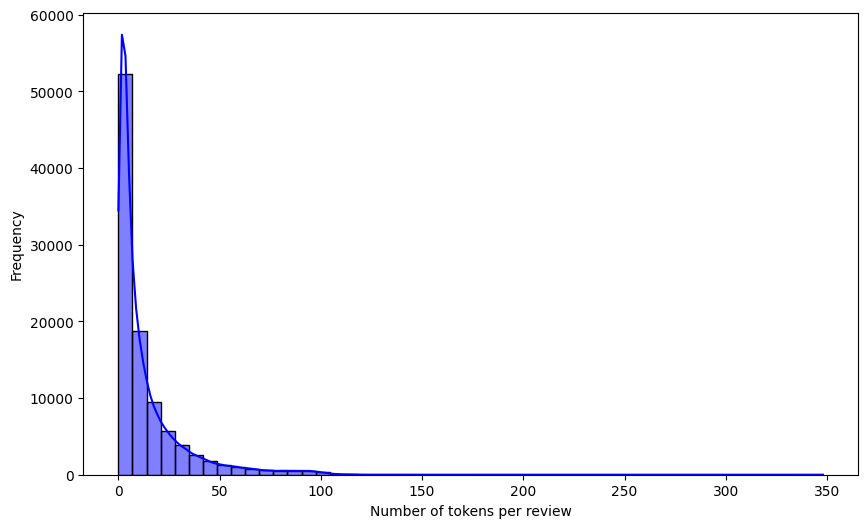

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df_mini['num_tokens'], kde=True, bins=50, color='blue')
plt.xlabel('Number of tokens per review')
plt.ylabel('Frequency')

In [50]:
def remove_short_lines(df, length=5):
    return df.loc[df['review_text'].str.count(" ") < length]

remove_short_lines(df_mini).head(20)

,review_text,review_rating,review_likes,num_tokens
3131012,I hate this app,1,0,4
3151445,Awesome and relaxing too,5,0,4
687194,Great and simple to use.,5,0,5
2350308,Love it!,5,0,2
1303162,Love It,5,0,2
1292450,I LOVE THIS SO MUCHHH,5,0,5
3151996,Boycott this app,1,0,3
1700573,Good,5,0,1
1040942,Worth every penny,5,0,3
2549281,Nice,5,0,1


In [ ]:
# %%script false --no-raise-error

from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')


df['num_tokens'] = df['review_text'].apply(lambda text: 0 if not isinstance(text, str) else len(TextBlob(text).words))

plt.figure(figsize=(10, 6))
sns.histplot(df['num_tokens'], kde=True, bins=50, color='blue')
plt.xlabel('Number of tokens per review')
plt.ylabel('Frequency')
df.drop(columns=['num_tokens'], inplace=True)

KeyboardInterrupt: 

In [43]:
df_mini[[0]]

KeyError: "None of [Index([0], dtype='int32')] are in the [index]"

Since the reviews are quite short, we do not need to split them using text splitters

In [ ]:
# import sys
# module_name = "faiss"
# if module_name in sys.modules:
#     del sys.modules[module_name]

In [ ]:
import os
import pickle
import faiss
from langchain.storage import LocalFileStore
from langchain.vectorstores import FAISS
from langchain.schema import Document
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

models = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'multi-qa-MiniLM-L6-dot-v1': 'sentence-transformers/multi-qa-MiniLM-L6-dot-v1',
    'paraphrase-MiniLM-L6-v2': 'sentence-transformers/paraphrase-MiniLM-L6-v2',
}

def select_model(m_key):
    if m_key not in models:
        raise ValueError(f'Model key is not found')
    return SentenceTransformer(m_key, device=device)

# import faiss
# import torch

# # Assume you have an index (e.g. a flat index on CPU)
# cpu_index = faiss.IndexFlatL2(128)

# if torch.cuda.is_available():
#     print("Using FAISS GPU")
#     # Create GPU resources and transfer the index to GPU 0
#     res = faiss.StandardGpuResources()
#     gpu_index = faiss.index_cpu_to_gpu(res, 0, cpu_index)
#     index = gpu_index
# else:
#     print("Using FAISS CPU")
#     index = cpu_index

# # Now use `index` for your similarity search

# def encode_in_batches(texts, embedding_model, batch_size=512):
#     sample_emb = embedding_model.encode([df.iloc[0]['review_text']], device=device)
#     emb_dim = len(sample_emb[0])

#     index = faiss.IndexFlatL2(emb_dim)

#     for i in tqdm(range(0, len(texts), batch_size), desc="Encoding batches"):
#         batch_texts = texts[i:i + batch_size]
#         emb = embedding_model.encode(batch_texts, device=device)
#         index.add(emb)

#     print("Compressing index")
#     m = 64  # Number of sub-vectors
#     clusters = 100  # Number of clusters
#     index = faiss.IndexIVFPQ(index, emb_dim, clusters, m, 8)  # IVF with PQ (100 clusters, 8-bit codes)

#     return index

def encode_in_batches(texts, embedding_model, batch_size=512):
    # Get embedding dimension
    sample_emb = embedding_model.encode([texts[0]], device=device)
    emb_dim = sample_emb.shape[1] if len(sample_emb.shape) > 1 else sample_emb.shape[0]

    num_vectors = len(texts)
    
    # Dynamically adjust number of clusters
    clusters = min(256, max(10, num_vectors // 40))  

    if num_vectors < 9984:
        print(f"Dataset has only {num_vectors} vectors. Using IndexFlatL2 instead.")
        index = faiss.IndexFlatL2(emb_dim)  # Flat index (no training needed)
    else:
        print(f"Using {clusters} clusters for IVF-PQ.")

        quantizer = faiss.IndexFlatL2(emb_dim)
        index = faiss.IndexIVFPQ(quantizer, emb_dim, clusters, 64, 8)

        # Collect training data
        training_data = []
        for i in tqdm(range(0, num_vectors, batch_size), desc="Encoding batches (Training)"):
            batch_texts = texts[i:i + batch_size]
            emb = embedding_model.encode(batch_texts, device=device).astype(np.float32)
            training_data.append(emb)
            if len(training_data) * batch_size >= clusters * 40:
                break

        training_data = np.vstack(training_data)
        print(f"Training IVF-PQ with {training_data.shape[0]} vectors...")
        index.train(training_data)

    # Add vectors
    for i in tqdm(range(0, num_vectors, batch_size), desc="Encoding batches (Indexing)"):
        batch_texts = texts[i:i + batch_size]
        emb = embedding_model.encode(batch_texts, device=device).astype(np.float32)
        index.add(emb)

    print("Index built successfully!")
    return index

def gen_emb_store(df, m_key, cache_dir = './cache'):
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # cache_file = os.path.join(cache_dir, f'{m_key}-embeddings.pickle')
    cache_file = os.path.join(cache_dir, f"{m_key}-index.idx")

    if os.path.exists(cache_file):
        print(f'Loading embedding from cache: {cache_file}')
        # with open(cache_file, 'rb') as f:
        #     vector_store = pickle.load(f)
        # embed_model = select_model(m_key)

        #load the faiss index
        vector_store = faiss.read_index(f"{cache_dir}/{m_key}-index.idx")
        embed_model = select_model(m_key)

    else:
        print(f'Generating embeddings for model: {m_key}')
        embed_model = select_model(m_key)
        texts = df['review_text'].tolist()
        vector_store = encode_in_batches(texts, embed_model)

        faiss.write_index(vector_store, f"{cache_dir}/{m_key}-index.idx")

    return vector_store, embed_model

def compare_models(df, model_keys, cache_dir='./cache'):
    results = {}
    for m_key in model_keys:
        print(f'Processing model: {m_key}')
        vector_store, embedder = gen_emb_store(df, m_key, cache_dir)
        if vector_store is None:
            raise ValueError(f"Vector store creation failure for {m_key}")

        results[m_key] = (vector_store, embedder)
    return results


In [ ]:
from langchain.schema import Document
from tqdm import tqdm

def documents_from_df(df, text_field="review_text", batch_size=256):
    """
    Convert a DataFrame into a list of Document objects.
    The text_field parameter indicates which column holds the text.
    """
    # Convert each row to a dictionary and use the selected text_field for page_content.
    records = df.to_dict(orient="records")
    #Documentise the df in BATCHES
    docs = []
    for idx in tqdm(range(0, len(records), batch_size), desc="creating documents"):
        batch_records = records[idx: idx + batch_size]
        docs.extend([Document(page_content=rec[text_field], metadata=rec) for rec in batch_records])

    return docs

    # return [Document(page_content=rec[text_field], metadata=rec) for rec in records]

        
    # store = LocalFileStore(cache_dir)
    # embedder = CacheBackedEmbeddings.from_bytes_store(
    #     embed_model, store, namespace = m_key
    # )
    # vector_store = FAISS.from_documents(docs, embedder)

    # with open(cache_file, 'wb') as f:
    #     pickle.dump(vector_store, f)
    # print(f'Embeddings saved to cache: {cache_file}')

In [ ]:
import time


if False:
    sample_docs = df[:5000]

    def time_for_m(m_key, docs):
        start_time = time.time()
        gen_emb_store(docs, m_key)
        end_time = time.time()
        return end_time - start_time

    num_docs = len(df)
    sample_size = len(sample_docs)

    for m in models:
        time_taken = time_for_m(m, sample_docs)
        print(f"Time taken for {m}: {time_taken} seconds")
        est_time_per_m = (time_taken / sample_size) * num_docs
        print(f"Estimated time for {m} on full dataset: {est_time_per_m} seconds")

In [ ]:
import numpy as np

def similarity_search(query, embedding_model, index, k=20):
    """Perform similarity search using FAISS."""
    
    # Encode query
    query_embedding = embedding_model.encode([query], device=device)
    
    # Ensure correct dtype and shape
    query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)

    # Safety checks
    if index.ntotal == 0:
        raise ValueError("FAISS index is empty. Add vectors before querying.")

    if query_embedding.shape[1] != index.d:
        raise ValueError(f"Embedding dimension mismatch: Query({query_embedding.shape[1]}) vs Index({index.d})")

    try:
        distances, indices = index.search(query_embedding, k)
        return distances, indices
    except Exception as e:
        print("Error in FAISS search:", e)
        return None, None

def retrieve_answers(query, index, embedding_model, k=20):
    """Retrieve top-k similar documents for a query."""
    distances, indices = similarity_search(query, embedding_model, index, k)

    if indices is None:
        return []

    doc_texts = [df.iloc[i]['review_text'] for i in indices[0] if i >= 0]
    return doc_texts

# Test similarity search
# sample_query = df.iloc[0]['review_text']
# sample_index, sample_embedder = results['all-MiniLM-L6-v2']

# distances, indices = similarity_search(sample_query, sample_embedder, sample_index)
# if distances is not None:
#     print(distances, indices)

# Test answer query
# sample_query = 'What do people like about Spotify?'

# for m_key in models.keys():
#     answer = retrieve_answers(sample_query, m_key)
#     print(f"Model: {m_key}")
#     print(answer)


Based on the quality of documents retrieved and the time it has taken to process, we proceed with the first model: **paraphrase-MiniLM-L6-v2**.

In [ ]:
chosen_model = "paraphrase-MiniLM-L6-v2"

In [ ]:
index,model = gen_emb_store(df, chosen_model)

In [ ]:
# Test the retrevial of chosen_model
sample_query = 'What do people like about Spotify?'


answer = retrieve_answers(sample_query, index, model,k=100)
for i,ans in enumerate(answer):
    print(f"{i+1}: {ans}")

## Adding LLM and a building retrieval chain

In [ ]:
import os
from langchain.schema import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.in_memory import InMemoryDocstore
from langchain.embeddings import CacheBackedEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
import pickle
from tqdm import tqdm
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

def batch_add(docs, embedder, batch_size=512):
    batch = docs[0:batch_size]
    vector_store = FAISS.from_documents(batch, embedder)
    print('one batch added')
    for i in tqdm(range(batch_size, len(docs), batch_size), desc="Adding batches"):
        batch = docs[i:i + batch_size]
        temp = FAISS.from_documents(batch, embedder)
        vector_store.merge_from(temp)

    return vector_store

cache_dir = "cache"
cache_file = os.path.join(".", cache_dir, f"{chosen_model}-embeddings.pickle")
print(f"Cache file: {cache_file}")
embed_model = HuggingFaceEmbeddings(model_name=f"{chosen_model}", model_kwargs={"device": "cuda"})

if os.path.exists(cache_file):
    print(f'Loading embedding from cache: {cache_file}')
    with open(cache_file, 'rb') as f:
        vector_store = pickle.load(f)
        
else:
    print(f'Generating embeddings for model: {chosen_model}')
    store = LocalFileStore(cache_dir)
    embedder = CacheBackedEmbeddings.from_bytes_store(embed_model, store, namespace=f"{chosen_model}")
    print("embedder loaded")
    docs = documents_from_df(df)
    print("generated docs")
    vector_store = batch_add(docs, embedder)

    with open(cache_file, 'wb') as f:
        pickle.dump(vector_store, f)
    print(f'Embeddings saved to cache: {cache_file}')

# vector_store = results['all-MiniLM-L6-v2'][0]
# documents = documents_from_df(df)
# doc_dict = {i: doc for i, doc in enumerate(documents)}
# doc_store = InMemoryDocstore({i: doc for i, doc in enumerate(documents)})
# index_to_docstore_id = {i: i for i in range(len(documents))}
pathlib.PosixPath = temp

retriever = vector_store.as_retriever()

In [ ]:
import torch

# torch.backends.cuda.enable_flash_sdp(True)
# torch.backends.cuda.enable_math_sdp(False)
# torch.backends.cuda.enable_mem_efficient_sdp(False)

In [ ]:
import transformers
from huggingface_hub import login
import os

# llm_model = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# llm_model = 'meta-llama/Llama-2-7b-chat-hf'
llm_model = "../model"

# hf_token = os.getenv('HUGGINGFACE_HUB_TOKEN') 
# login(token=hf_token)


bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )

model_config = transformers.AutoConfig.from_pretrained(llm_model)


model = transformers.AutoModelForCausalLM.from_pretrained(
        llm_model,
        config=model_config,
        quantization_config=bnb_config,
        trust_remote_code=True,
        device_map='auto',
        torch_dtype=torch.float16       # use float16 to reduce memory footprint
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(llm_model)

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=0.5,
    max_new_tokens=250
)

In [ ]:
from langchain_huggingface import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

In [ ]:
from langchain import PromptTemplate

prompt_template = """
User question: {question}

Answer the user's question using the following context.

Follow these rules in order to answer the user's question:
1) Your answer should be short (maximum 3 short coherent sentences).
2) Use the dataset information on Google Store reviews for Spotify to extract actionable insights.
3) Your answer should be a coherent question answering the question with the given context.

Context:
{context}

Your answer:
"""

prompt = PromptTemplate(template = prompt_template, input_variables=["question", "context"])

In [ ]:
from langchain.chains import ConversationalRetrievalChain

qa = ConversationalRetrievalChain.from_llm(
    llm,
    #verbose=True,
    retriever=retriever,
    combine_docs_chain_kwargs={"prompt": prompt},
    return_source_documents=True,
)

In [ ]:
query = "What do people like about Spotify?"
result = qa({"question": query, "chat_history": []})
print(result['answer'])

In [ ]:
from transformers import AutoTokenizer

def truncate_context(context):
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
    max_tokens = 510  # leave space for special tokens and question tokens

    tokens = tokenizer.encode(context, add_special_tokens=False)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
        context = tokenizer.decode(tokens)
    return context

In [ ]:


def generate_text_from_query(query, context):

    model = transformers.pipeline(
        task="question-answering",
        model="distilbert-base-cased-distilled-squad",
        tokenizer=tokenizer,
        # task="text-generation",
        return_full_text=True,
        temperature=0.5,
        max_new_tokens=510
    )

    context = truncate_context(context)
    # Pass both values to the QA pipeline
    return model(question=query, context=context)

In [ ]:
index, model = gen_emb_store(df, chosen_model, cache_dir='./cache')

In [ ]:

def answer_query(query):
    retrevial_result = retrieve_answers(query, index, model)
    context = " ".join(retrevial_result)
    return generate_text_from_query(query, context)

# Then run your query
print(answer_query("What do people like about Spotify?"))

In [ ]:
answer_query("What do users indiate they like about Spotify?")